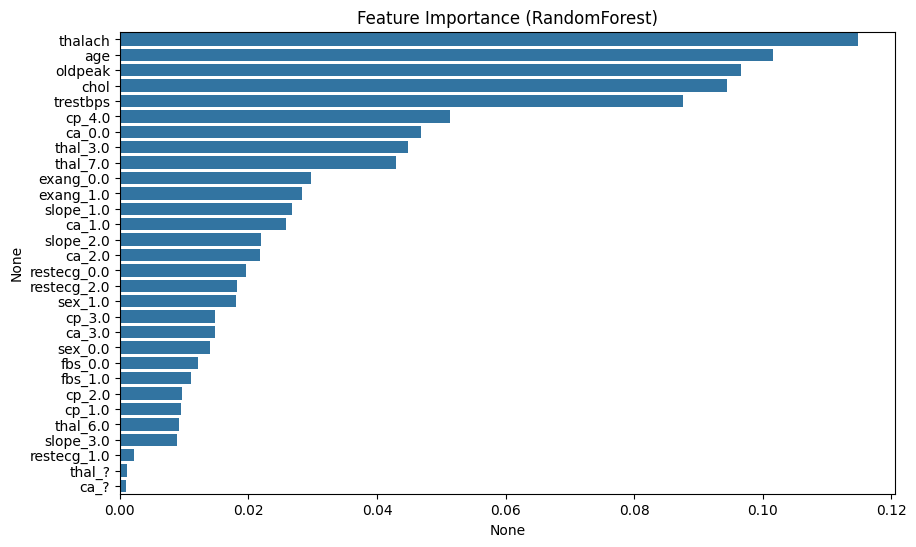

Selected features by RFE: ['sex_0.0' 'cp_4.0' 'restecg_0.0' 'exang_0.0' 'slope_1.0' 'ca_0.0'
 'ca_2.0' 'ca_3.0' 'thal_3.0' 'thal_7.0']
Selected features by Chi2: ['cp_3.0' 'cp_4.0' 'exang_1.0' 'slope_1.0' 'slope_2.0' 'ca_0.0' 'ca_2.0'
 'ca_3.0' 'thal_3.0' 'thal_7.0']
Final selected features: ['ca_2.0', 'ca_3.0', 'slope_2.0', 'cp_3.0', 'thal_7.0', 'sex_0.0', 'restecg_0.0', 'cp_4.0', 'exang_0.0', 'slope_1.0', 'exang_1.0', 'ca_0.0', 'thal_3.0']
Saved reduced dataset with selected features.


d:\Heart_Disease_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
d:\Heart_Disease_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
d:\Heart_Disease_Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which 

In [1]:
# ===== Imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# ===== Load data and preprocessor =====
df = pd.read_csv("data/heart_disease_clean.csv")
preprocessor = joblib.load("models/preprocessor.pkl")

X = df.drop("target", axis=1)
y = df["target"]

# Apply preprocessing
X_pre = preprocessor.fit_transform(X)

# ===== 1. Feature importance (RandomForest) =====
rf = RandomForestClassifier(random_state=42)
rf.fit(X_pre, y)

importances = rf.feature_importances_

# Get feature names from preprocessor
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_cols = ohe.get_feature_names_out(preprocessor.transformers_[1][2])
num_cols = preprocessor.transformers_[0][2]
feature_names = np.concatenate([num_cols, cat_cols])

feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Feature Importance (RandomForest)")
plt.show()

# ===== 2. Recursive Feature Elimination (RFE) =====
log_reg = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
rfe = RFE(log_reg, n_features_to_select=10)
rfe.fit(X_pre, y)

rfe_features = feature_names[rfe.support_]
print("Selected features by RFE:", rfe_features)

# ===== 3. Chi-Square Test =====
# Scaling X to non-negative values for chi2
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_pre)

chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(X_scaled, y)

chi2_features = feature_names[chi2_selector.get_support()]
print("Selected features by Chi2:", chi2_features)

# ===== Final selected features =====
# ناخد اتحاد (union) أو تقاطع (intersection) بين الطرق
final_features = list(set(rfe_features) | set(chi2_features))
print("Final selected features:", final_features)

# ===== Save reduced dataset =====
X_selected = pd.DataFrame(X_pre, columns=feature_names)[final_features]
X_selected["target"] = y.values
X_selected.to_csv("data/heart_disease_selected.csv", index=False)

print("Saved reduced dataset with selected features.")
